In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## GRAD-CAM (Gradient weighted Class Activation Map Implamentation)

- I sincerely thank [this](https://www.hackevolve.com/where-cnn-is-looking-grad-cam/) blog post for providing support for implemtation.
- With some tweaks In the aove blogs coe I have implemented GRAD-CAM in my code.

### please go through the above blog post .Apart from that i have made the following changes for custom implementation

- ```cv2.imshow()``` does not directly work in colab so i have used matplotlib for plotting image
- Before applying ```cv2.applyColorMap()``` and ```cv2.addWeighted()``` to the image . Image pixels should be converted to a 8 bit integer. Else ```cv2.applyColorMap()``` will throw error
- If we use normal addition for adding image and heatmap. In that scenario if the first image have 250 as pixel value and second have 10 as pixel then effective pixel value will be (250+10)%256 == 4 because pixel value is 8 byte integer. But if we use ``cv2.addWeighted()`` it will handle the overflow value and stop at 255. 
- Have converted BGR to RGB for plotting in matplotlib

## Grad cam architecture
![gradcamarch](images/gradcamarch.png)
## Grad cam sample output
![gradcamsample](images/gradcamsamp.png)

In [0]:
def get_heat_map_images(img, model, conv_layer,channels, class_idx = None):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  if not class_idx:
    class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  grads = K.gradients(class_output, conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  b,g,r = cv2.split(superimposed_img)   
  superimposed_img = cv2.merge([r,g,b])
  return img, superimposed_img

## Ploting Grad cam images for last two layers of from final layer
- We can observe that block5 is consentrating more on final class while remaining previous blocks are focusing on small features

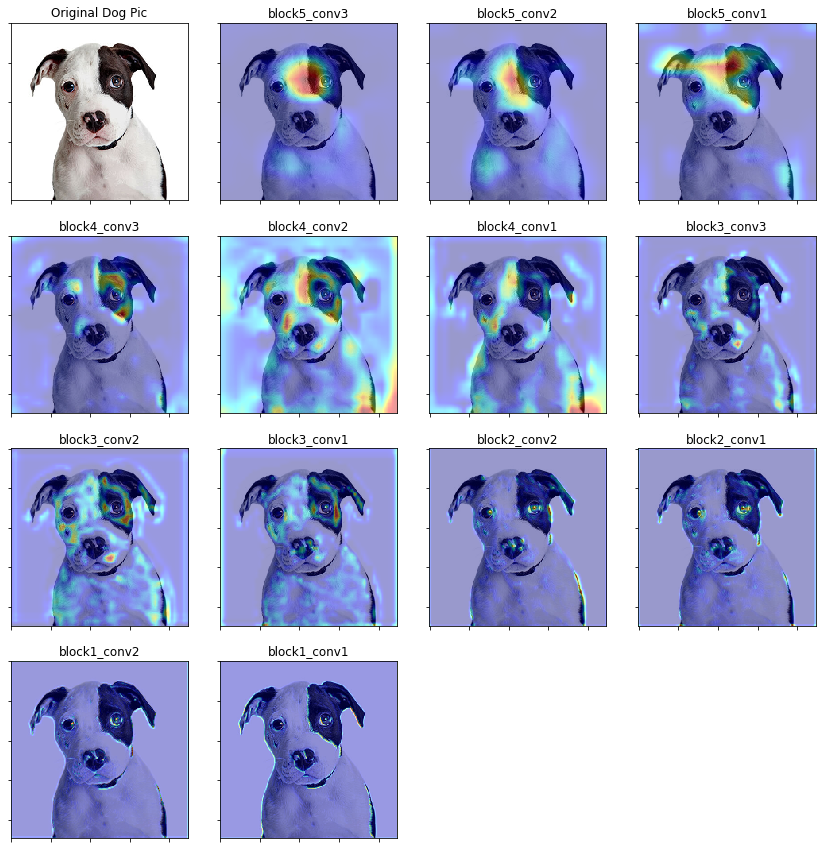

In [0]:
import matplotlib.pyplot as plt
layers_list = [("block5_conv3",512),("block5_conv2",512),("block5_conv1",512),("block4_conv3",512),("block4_conv2",512),("block4_conv1",512),("block3_conv3",256),("block3_conv2",256),("block3_conv1",256),("block2_conv2",128),("block2_conv1",128),("block1_conv2",64),("block1_conv1",64)]

plt.figure(figsize = (15,15))

ax1 = plt.subplot(4, 4, 1)
plt.axis('on')
ax1.imshow(dog)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_aspect('equal')
ax1.set_title("Original Dog Pic")
plt.subplots_adjust(wspace=0, hspace=0.2)

for i,(layer,channels) in enumerate(layers_list):
  last_conv_layer = model.get_layer(layer)
  _, superimposed_img = get_heat_map_images(dog, model,last_conv_layer, channels )

  ax1 = plt.subplot(4, 4, i+2)
  plt.axis('on')
  ax1.imshow(superimposed_img)
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
  ax1.set_title(layer)
  plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

## Plotted Grad cam for Image of index 837
- How ever index 836 and 837 indices are showing almost same results as they both belong to glasses.
- We can observe grad cam highliting sun shades

837 Tensor("strided_slice_69:0", shape=(?,), dtype=float32)


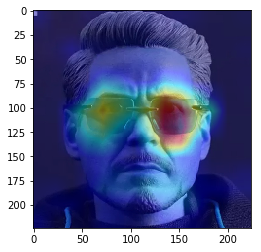

In [0]:
sun_shades = io.imread("./images/stark.jpg")
sun_shades = cv2.resize(sun_shades, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
sun_shades, superimposed_sun_shades = get_heat_map_images(sun_shades, model,model.get_layer("block5_conv3"), 512, class_idx = 837)#836,837
plt.imshow(superimposed_sun_shades)

## Plotted grad cam of remainig layers for stark image


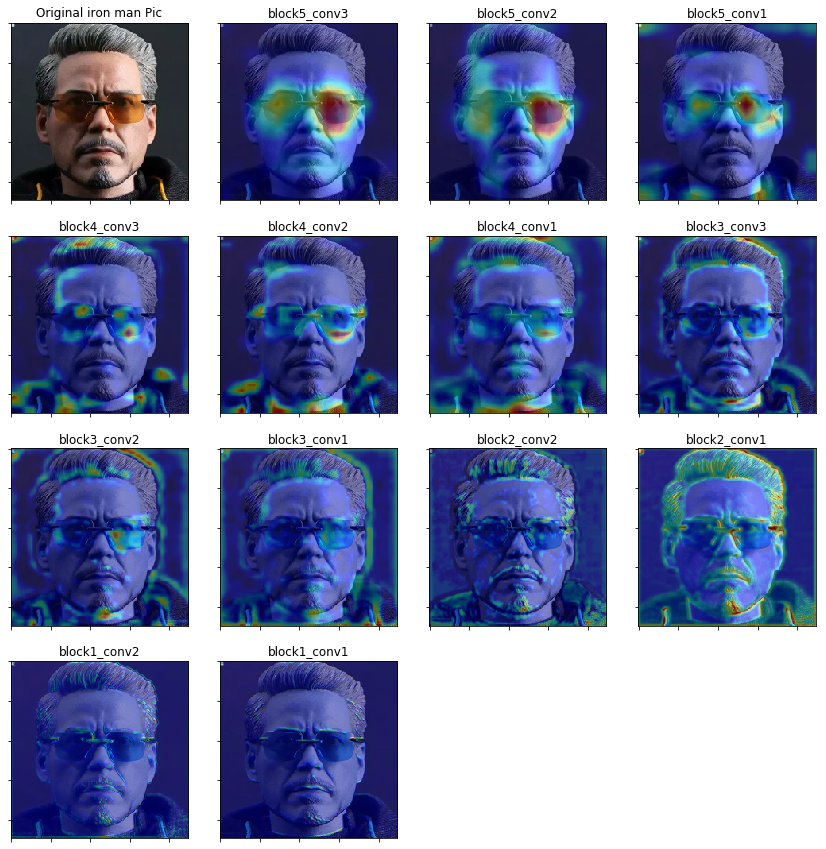

In [0]:
import matplotlib.pyplot as plt
layers_list = [("block5_conv3",512),("block5_conv2",512),("block5_conv1",512),("block4_conv3",512),("block4_conv2",512),("block4_conv1",512),("block3_conv3",256),("block3_conv2",256),("block3_conv1",256),("block2_conv2",128),("block2_conv1",128),("block1_conv2",64),("block1_conv1",64)]

plt.figure(figsize = (15,15))

ax1 = plt.subplot(4, 4, 1)
plt.axis('on')
ax1.imshow(sun_shades)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_aspect('equal')
ax1.set_title("Original iron man Pic")
plt.subplots_adjust(wspace=0, hspace=0.2)

for i,(layer,channels) in enumerate(layers_list):
  last_conv_layer = model.get_layer(layer)
  _, superimposed_img = get_heat_map_images(sun_shades, model,last_conv_layer, channels )

  ax1 = plt.subplot(4, 4, i+2)
  plt.axis('on')
  ax1.imshow(superimposed_img)
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
  ax1.set_title(layer)
  plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()